In [21]:
import numpy as np
import scipy.linalg
import numpy.linalg as la
import matplotlib.pyplot as plt

In [22]:
def XOR_data(nPoints, fs, k1, k2, sig_dur, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    N = int(fs * sig_dur)
    #dft matrix
    A = scipy.linalg.dft(N, scale=None)
    
    # positive examples
    n_pos = int(nPoints/2)
    c = np.zeros((N, n_pos), dtype='complex')
    c[k1, :int(n_pos/2)] = np.random.normal(loc=0, scale=1, size=(int(n_pos/ 2), 2)).view(np.complex).flatten()
    c[k2, int(n_pos/2):] = np.random.normal(loc=0, scale=1, size=(int(n_pos/ 2), 2)).view(np.complex).flatten()
    c /= la.norm(c, axis=0)
    X_pos = np.sqrt(2) * (A @ c).T.real
    
    # negative egs
    n_neg = int(nPoints/2)
    
    # mixed freq
    c = np.zeros((N, int(n_neg/2)), dtype='complex')
    c[[k1, k2]] = np.random.normal(loc=0, scale=1, size=(2, int(n_neg/2), 2)).view(np.complex).squeeze(axis=2)
    X_mixed = (A @ c).T.real
    X_mixed /= np.std(X_mixed, axis=1).reshape(-1, 1)
    
    # noise
    c = np.random.normal(loc=0, scale=1, size=(N, int(n_neg / 2), 2)).view(np.complex).squeeze(axis=2)
    noise = (A @ c).T.real
    noise /= np.std(noise, axis=1).reshape(-1, 1)
    
    X_neg = np.row_stack((X_mixed, noise))
    
    X = np.vstack((X_pos, X_neg))
    y = np.hstack((np.ones(n_pos), np.ones(n_neg) * -1))
    
    return X, y

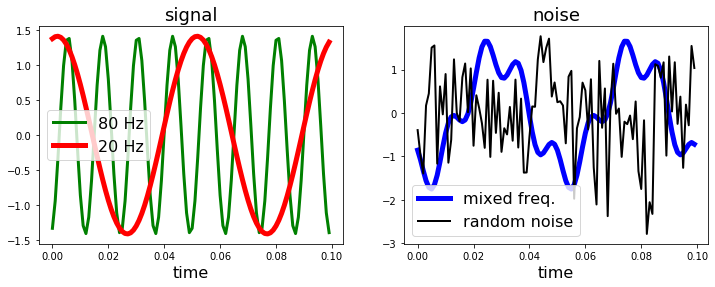

In [127]:
n_points, fs, sig_dur = 5000, 1000, 0.1
k1, k2 = 2, 8
freq = [int(k1/ sig_dur), int(k2 / sig_dur)]
X, y = XOR_data(n_points, fs, k1, k2, sig_dur, seed=0)

n_points_quarter = int(n_points/4)
N = int(fs * sig_dur)
t = np.arange(N) / fs
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
plt.title('signal', fontsize=18)
plt.plot(t, X[1250], 'g', lw=3, label='%d Hz' % freq[1])
plt.plot(t, X[0], 'r', lw=5, label='%d Hz' % freq[0])
plt.legend(fontsize=16)
plt.xlabel('time', fontsize=16)


ax = fig.add_subplot(122)
plt.title('noise', fontsize=18)
plt.plot(t, X[2501], 'b', lw=5, label='mixed freq.')
plt.plot(t, X[-1], 'k', lw=2, label='random noise')
plt.legend(fontsize=16)
plt.xlabel('time', fontsize=16)

plt.savefig('figures/XOR/data.png')

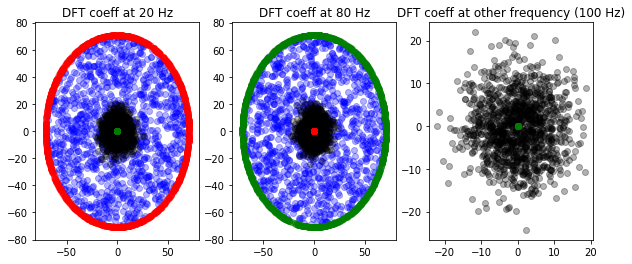

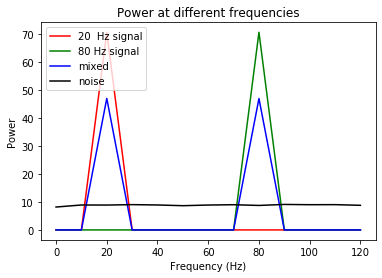

In [128]:
X_pos = X[y == 1]
X_neg = X[y == -1]

N = int(fs * sig_dur)
A = scipy.linalg.dft(N)

dft_pos = X_pos @ A
dft_neg = X_neg @ A

# plot dft coeffs.
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(131)
plt.title('DFT coeff at %d Hz' % freq[0])
plt.scatter(dft_neg[:n_points_quarter, k1].real, dft_neg[:n_points_quarter, k1].imag, c='b', alpha=0.3)
plt.scatter(dft_neg[n_points_quarter:, k1].real, dft_neg[n_points_quarter:, k1].imag, c='k', alpha=0.3)
plt.scatter(dft_pos[:n_points_quarter, k1].real, dft_pos[:n_points_quarter, k1].imag, c='r', alpha=0.3)
plt.scatter(dft_pos[n_points_quarter:, k1].real, dft_pos[n_points_quarter:, k1].imag, c='g', alpha=0.3)
# plt.scatter(dft_neg[:, k1].real, dft_neg[:, k1].imag, c='k', alpha=0.3)
# plt.scatter(dft_pos[:, k1].real, dft_pos[:, k1].imag, c='r')

ax = fig.add_subplot(132)
plt.title('DFT coeff at %d Hz' % freq[1])
plt.scatter(dft_neg[:n_points_quarter, k2].real, dft_neg[:n_points_quarter, k2].imag, c='b', alpha=0.3)
plt.scatter(dft_neg[n_points_quarter:, k2].real, dft_neg[n_points_quarter:, k2].imag, c='k', alpha=0.3)
plt.scatter(dft_pos[:n_points_quarter, k2].real, dft_pos[:n_points_quarter, k2].imag, c='r', alpha=0.3)
plt.scatter(dft_pos[n_points_quarter:, k2].real, dft_pos[n_points_quarter:, k2].imag, c='g', alpha=0.3)
# plt.scatter(dft_neg[:, k2].real, dft_neg[:, k2].imag, c='k', alpha=0.3)
# plt.scatter(dft_pos[:, k2].real, dft_pos[:, k2].imag, c='r')

k =10
ax = fig.add_subplot(133)
plt.scatter(dft_neg[:n_points_quarter, k].real, dft_neg[:n_points_quarter, k].imag, c='b', alpha=0.3)
plt.scatter(dft_neg[n_points_quarter:, k].real, dft_neg[n_points_quarter:, k].imag, c='k', alpha=0.3)
plt.scatter(dft_pos[:n_points_quarter, k].real, dft_pos[:n_points_quarter, k].imag, c='r', alpha=0.3)
plt.scatter(dft_pos[n_points_quarter:, k].real, dft_pos[n_points_quarter:, k].imag, c='g', alpha=0.3)
plt.title('DFT coeff at other frequency (%d Hz)' % int(k / sig_dur))
# plt.scatter(dft_neg[:, k].real, dft_neg[:, 14].imag, c='k', alpha=0.3)
# plt.scatter(dft_pos[:, k].real, dft_pos[:, 14].imag, c='r')

# # power at different frequencies
power_f1 = np.mean(np.abs(dft_pos[:n_points_quarter]), axis=0)
power_f2 = np.mean(np.abs(dft_pos[n_points_quarter:]), axis=0)
power_mixed = np.mean(np.abs(dft_neg[:n_points_quarter]), axis=0)
power_noise = np.mean(np.abs(dft_neg[n_points_quarter:]), axis=0)
# power_pos = np.mean(np.abs(dft_pos), axis=0)
# power_neg = np.mean(np.abs(dft_neg), axis=0)

n = 13
fig = plt.figure()
plt.title('Power at different frequencies')
plt.plot(np.arange(n) / sig_dur, power_f1[:n], 'r', label='%d  Hz signal' % freq[0] )
plt.plot(np.arange(n) / sig_dur, power_f2[:n], 'g', label='%d Hz signal' % freq[1])
plt.plot(np.arange(n) / sig_dur, power_mixed[:n], 'b', label='mixed')
plt.plot(np.arange(n) / sig_dur, power_noise[:n], 'k', label='noise')

# plt.plot(np.arange(n) / sig_dur, power_pos[:n], 'r', label='signal')
# plt.plot(np.arange(n) / sig_dur, power_neg[:n], 'k', label='noise')
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.legend(loc='upper left', fontsize=10)

plt.savefig('figures/XOR/dft_analysis.png')

In [96]:
# check input statistics
X_f1, X_f2 = X_pos[:n_points_quarter], X_pos[n_points_quarter:]
X_mixed, X_noise = X_neg[:n_points_quarter], X_neg[n_points_quarter:]

# RMSE 
print(np.mean(la.norm(X_f1, axis=1)), np.mean(la.norm(X_f2, axis=1)))
print(np.mean(la.norm(X_mixed, axis=1)), np.mean(la.norm(X_noise, axis=1)))

# mean
print(np.mean(X_f1), np.mean(X_f2))
print(np.mean(X_mixed), np.mean(X_noise))

# std
print(np.mean(np.std(X_f1, axis=1)), np.mean(np.std(X_f2, axis=1)))
print(np.mean(np.std(X_mixed, axis=1)), np.mean(np.std(X_noise,axis=1)))

10.0 10.0
10.0 10.051724974013915
5.258016244624741e-19 1.0835776720341527e-18
9.947598300641402e-20 -0.0015633418355162254
1.0 1.0
1.0 1.0


In [129]:
# classify the XOR dataset
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu, bp_weights_dft
from sklearn.utils import shuffle
import dask

In [98]:
# from dask.distributed import Client
# client = Client(threads_per_worker=7, n_workers=10)
# client

In [130]:
def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [131]:
X_perm, y_perm = shuffle(X, y, random_state=0)
# split into test/train
X_train, X_test, y_train, y_test = train_test_split(X_perm, y_perm, test_size=0.3, random_state=42)

In [157]:
%%time 
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

# classification
f_gaus = lambda M, N: bp_weights_dft(M, N, lowcut=k1, highcut=k2 + 1)
h = lambda x: x ** 2

weights = [('bandpass_dft', f_gaus), ('white noise', None)]
results = {wt:[] for (wt, func) in weights}
for n in n_features:
    for (wt, func) in weights:
        params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
                                            y_test) for _ in range(5)]
        results[wt].append(np.real(dask.compute(*lazy_results)))

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]
CPU times: user 24.2 s, sys: 7.57 s, total: 31.8 s
Wall time: 1min 39s


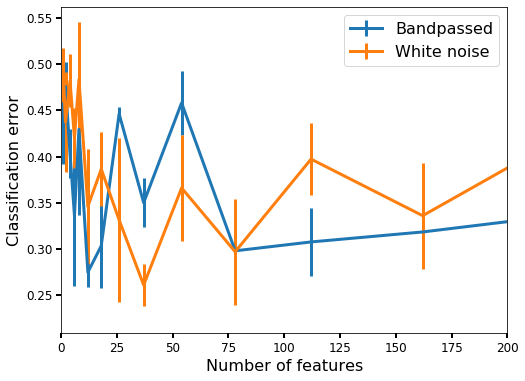

In [158]:
# compute mean
mean_err_bp, std_err_bp = np.mean(results['bandpass_dft'], axis=1), np.std(results['bandpass_dft'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], axis=1), np.std(results['white noise'], axis=1)

# plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_bp, yerr=std_err_bp, fmt='-', label='Bandpassed',  markersize=4, lw=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='White noise',  
            markersize=4, lw=3)
# ax.set_yscale('log')
plt.xlim([0, 200])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Classification error', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12, width=2, length=5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0, width=0)
plt.legend(loc = 'upper right', fontsize=16)

plt.savefig('figures/XOR/x^2_clf.png')